In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
df = pd.read_csv("flights.csv")

In [ ]:
print(df.head())

   id  year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0   0  2013      1    1     517.0             515        2.0     830.0   
1   1  2013      1    1     533.0             529        4.0     850.0   
2   2  2013      1    1     542.0             540        2.0     923.0   
3   3  2013      1    1     544.0             545       -1.0    1004.0   
4   4  2013      1    1     554.0             600       -6.0     812.0   

   sched_arr_time  arr_delay  ... flight  tailnum origin dest air_time  \
0             819       11.0  ...   1545   N14228    EWR  IAH    227.0   
1             830       20.0  ...   1714   N24211    LGA  IAH    227.0   
2             850       33.0  ...   1141   N619AA    JFK  MIA    160.0   
3            1022      -18.0  ...    725   N804JB    JFK  BQN    183.0   
4             837      -25.0  ...    461   N668DN    LGA  ATL    116.0   

   distance  hour  minute            time_hour                    name  
0      1400     5      15  2013-01-01

CREATE A DATE COLUMN

In [ ]:
df['date'] = pd.to_datetime(df[['year','month','day']])

daily_demand = df.groupby('date').size().reset_index(name='flights_count')

daily_demand.set_index('date', inplace=True)

In [ ]:
print(daily_demand.head())

            flights_count
date                     
2013-01-01            842
2013-01-02            943
2013-01-03            914
2013-01-04            915
2013-01-05            720


In [ ]:
import statsmodels.api as sm

arima_model = sm.tsa.ARIMA(daily_demand['flights_count'], order=(5,1,0))
arima_result = arima_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Forecast next 7 days
forecast = arima_result.forecast(steps=7)
print(forecast)

2014-01-01    831.667916
2014-01-02    920.990992
2014-01-03    872.757093
2014-01-04    847.540907
2014-01-05    907.145631
2014-01-06    862.142774
2014-01-07    840.747973
Freq: D, Name: predicted_mean, dtype: float64


VISUALIZE

In [ ]:
import matplotlib.pyplot as plt

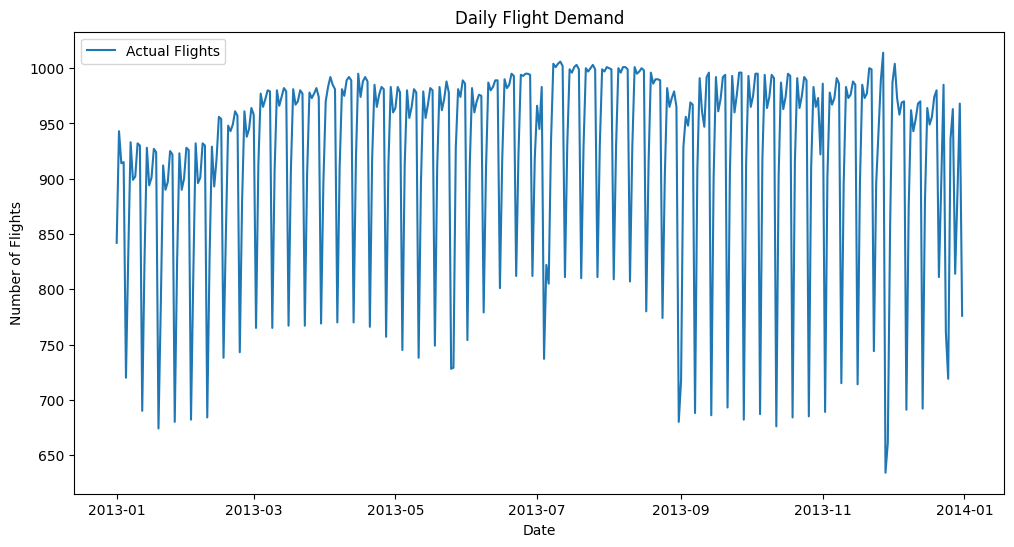

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(daily_demand.index, daily_demand['flights_count'], label='Actual Flights')
plt.title("Daily Flight Demand")
plt.xlabel("Date")
plt.ylabel("Number of Flights")
plt.legend()
plt.show()

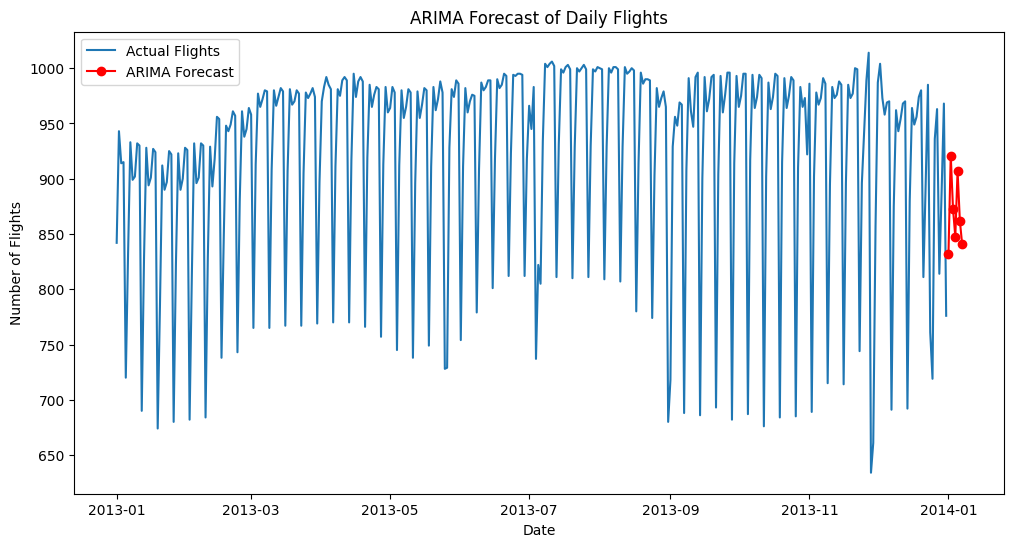

In [ ]:
forecast_index = pd.date_range(start=daily_demand.index[-1] + pd.Timedelta(days=1), periods=7)
plt.figure(figsize=(12,6))
plt.plot(daily_demand.index, daily_demand['flights_count'], label='Actual Flights')
plt.plot(forecast_index, forecast, label='ARIMA Forecast', color='red', marker='o')
plt.title("ARIMA Forecast of Daily Flights")
plt.xlabel("Date")
plt.ylabel("Number of Flights")
plt.legend()
plt.show()

PREPARE DATA FOR ML MODELS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [ ]:
df_ml = daily_demand.copy()
for lag in range(1, 8):
    df_ml[f'lag_{lag}'] = df_ml['flights_count'].shift(lag)

# Drop NaN rows
df_ml.dropna(inplace=True)

# Features and target
X = df_ml.drop('flights_count', axis=1)
y = df_ml['flights_count']

In [ ]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Scale features for models like SVM and LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

XGBOOST

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))


XGBoost RMSE: 84.67974480173815


SVM

In [ ]:
from sklearn.svm import SVR

svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

print("SVM RMSE:", np.sqrt(mean_squared_error(y_test, svm_pred)))

SVM RMSE: 77.72846265384511


LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm)

print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, lstm_pred)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
LSTM RMSE: 103.50252393510749


K MEANS

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use features like distance and air_time
df_cluster = df[['distance', 'air_time']].dropna()

# Optional: scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Fit KMeans (choose 3 clusters for simplicity)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(df_scaled)

# Add cluster info to original dataframe
df['cluster'] = df_cluster['cluster'].reindex(df_cluster.index)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


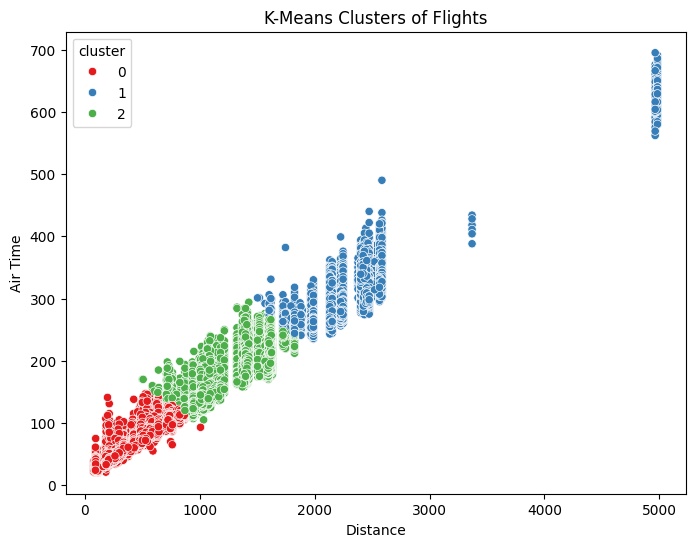

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='distance', y='air_time', hue='cluster', data=df_cluster, palette='Set1')
plt.title('K-Means Clusters of Flights')
plt.xlabel('Distance')
plt.ylabel('Air Time')
plt.show()


            distance    air_time
cluster                         
0         480.621583   78.668502
1        2443.163601  327.449353
2        1164.819014  165.533374


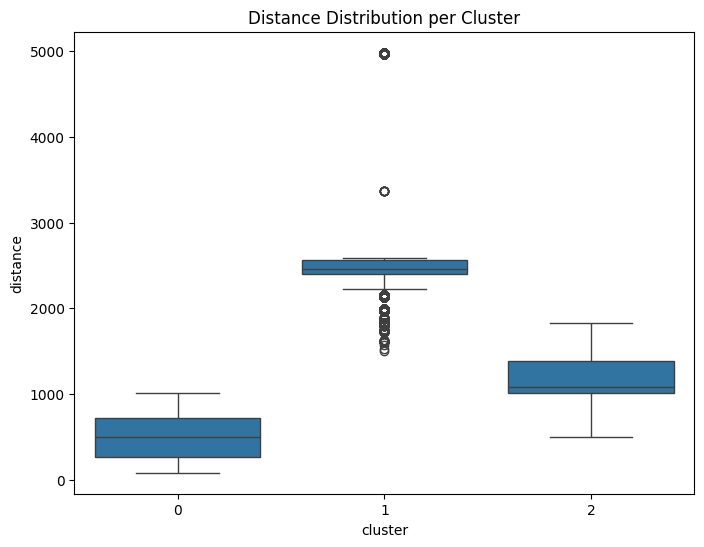

In [ ]:
cluster_stats = df_cluster.groupby('cluster')[['distance', 'air_time']].mean()
print(cluster_stats)

# Optional: boxplot for each cluster
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster', y='distance', data=df_cluster)
plt.title('Distance Distribution per Cluster')
plt.show()

Flights per cluster:
 cluster
0    156589
1     53991
2    116766
Name: count, dtype: int64


/tmp/ipython-input-1408298357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')


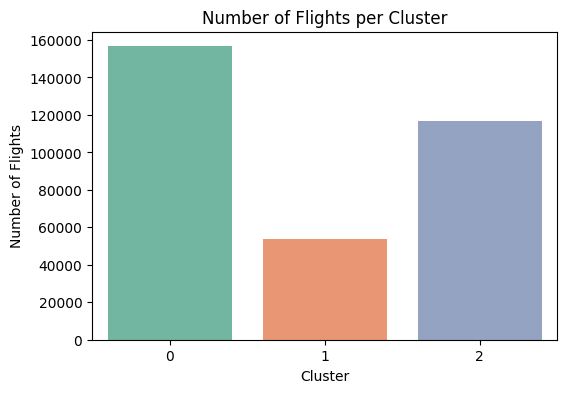

In [ ]:
# Count of flights in each cluster
cluster_counts = df_cluster['cluster'].value_counts().sort_index()
print("Flights per cluster:\n", cluster_counts)

# Bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
plt.xlabel('Cluster')
plt.ylabel('Number of Flights')
plt.title('Number of Flights per Cluster')
plt.show()


Average Distance and Air Time per Cluster:
             distance    air_time
cluster                         
0         480.621583   78.668502
1        2443.163601  327.449353
2        1164.819014  165.533374


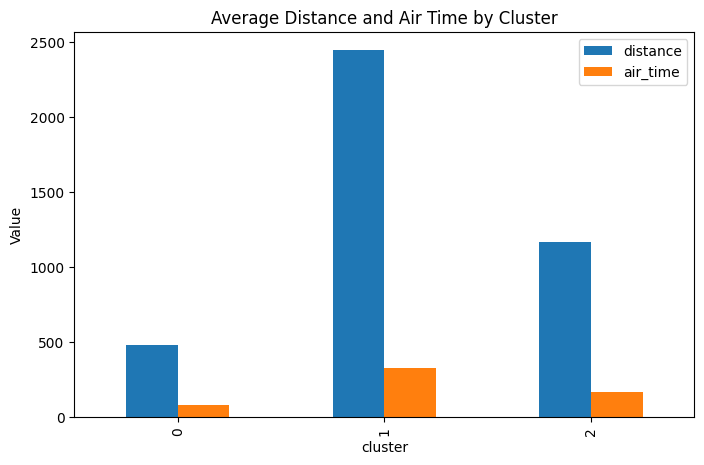

In [ ]:
# Already computed cluster_stats earlier
print("Average Distance and Air Time per Cluster:\n", cluster_stats)

# Plot
cluster_stats.plot(kind='bar', figsize=(8,5))
plt.title('Average Distance and Air Time by Cluster')
plt.ylabel('Value')
plt.show()
